<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Perceptron" data-toc-modified-id="Perceptron-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Perceptron</a></span><ul class="toc-item"><li><span><a href="#Implementation" data-toc-modified-id="Implementation-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Implementation</a></span></li><li><span><a href="#Data-preprocessing" data-toc-modified-id="Data-preprocessing-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Data preprocessing</a></span></li><li><span><a href="#Setosa-classification" data-toc-modified-id="Setosa-classification-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Setosa classification</a></span></li><li><span><a href="#Separation-Versicolour-from-Virginica" data-toc-modified-id="Separation-Versicolour-from-Virginica-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Separation Versicolour from Virginica</a></span></li></ul></li><li><span><a href="#MLP" data-toc-modified-id="MLP-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>MLP</a></span></li></ul></div>

In [81]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Perceptron

Implement the Perceptron algorithm using Python (incl. Numpy etc.) and use it on the
Iris-Dataset

Train the algorithm to separate Setosa from Versicolour and Virginica.
1. What happens if you use the algorithm to separate Versicolour from Virginica? (Evaluate multiple runs)
2. Find a way to solve the problem and obtain the accuracy.


## Implementation

In [2]:
def random_sample(arr, size=1):
    return arr[np.random.choice(len(arr), size=size, replace=False)]

In [3]:
class Perzeptron:
    def __init__(self, theta=1):
        self.theta = theta
        self.w = None

    def fit(self, X, y):
        Xy = self._merge(X, y)
        self.w = self._get_w(Xy)

    def predict(self, X):
        return [self._activate(x) for x in X.to_numpy()]

    def _merge(self, X, y):
        assert sorted(y.unique().tolist()) == [0, 1]
        return pd.concat([X, y], axis=1).to_numpy()

    def _get_w(self, Xy):
        dist = np.inf
        P = Xy[((Xy[:, 2] > 0))]
        w_ = np.average(P, axis=0)[:-1]
        w = w_
        while dist > self.theta:
            w = w_
            v_ = random_sample(Xy).reshape(3, )            
            v = v_[:-1]
            v_is_p = v_[-1]
            dot = np.dot(w, v)

            if v_is_p and dot > 0:
                continue
            elif v_is_p and dot <= 0:
                w_ = w + v
            elif not v_is_p and dot < 0:
                continue
            else:
                w_ = w - v

            dist = np.linalg.norm(w_ - w) 
        return w

    def _activate(self, x):
        return int(np.dot(self.w, x) > 0)

## Data preprocessing

In [4]:
df = pd.read_csv('iris.csv')

In [5]:
df_setosa = df.copy()
df_setosa['class'] = df_setosa['class'].apply(lambda c: 1 if c == 'Iris-setosa' else 0)
df_setosa.head()

sepal_length  sepal_width  petal_length  petal_width  class
0           5.1          3.5           1.4          0.2      1
1           4.9          3.0           1.4          0.2      1
2           4.7          3.2           1.3          0.2      1
3           4.6          3.1           1.5          0.2      1
4           5.0          3.6           1.4          0.2      1

**Let's reduce data dimensionality in order to be able easily visualize it and debug our perceptron implementation. It will cost us some accuracy, however, it isn't critical**

In [6]:
pca = PCA(n_components=4)
pca.fit(df_setosa.loc[:, df.columns != 'class'])
pca.explained_variance_ratio_

array([0.92461621, 0.05301557, 0.01718514, 0.00518309])

In [7]:
df_setosa_mini = df_setosa[['sepal_length', 'sepal_width', 'class']].copy()

<AxesSubplot:xlabel='sepal_length', ylabel='sepal_width'>

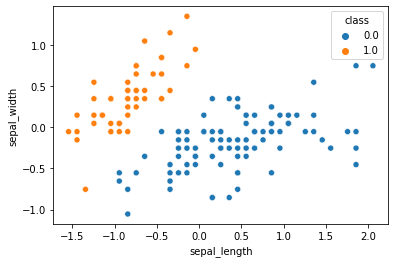

In [8]:
mean = np.average(np.array(df_setosa_mini)[:,0:2], axis=0)

df_setosa_mini_centered = df_setosa_mini - np.append(mean, 0)
sns.scatterplot(data=df_setosa_mini_centered, x="sepal_length", y="sepal_width", hue="class")

## Setosa classification

In [9]:
y = df_setosa_mini_centered['class']
X = df_setosa_mini_centered.loc[:, df_setosa_mini_centered.columns != 'class']

In [16]:
def min_accuracy(X, y, *, n_epoch=10, theta=4):    
    accuracies = []
    for i in range(n_epoch):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
        clf = Perzeptron(theta=theta)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))
    return min(accuracies)

In [17]:
min_accuracy(X, y, theta=.5)

0.92

**After centralizing the data and calculating the resulting accuracy of our classification we get promising results. We can distinguish Setosa from Versicolour and Virginica.**

## Separation Versicolour from Virginica

In [18]:
df_not_setosa = df.copy()
df_not_setosa = df_not_setosa[df_not_setosa['class'] != 'Iris-setosa']
df_not_setosa['class'] = df_not_setosa['class'].apply(lambda c: 1 if c == 'Iris-versicolor' else 0)

In [19]:
df_not_setosa_mini = df_not_setosa[['petal_length', 'petal_width', 'class']].copy()
mean = np.average(np.array(df_not_setosa_mini)[:,0:2], axis=0)

y = df_not_setosa_mini['class']
X = df_not_setosa_mini.loc[:, df_not_setosa_mini.columns != 'class']

min_accuracy(X, y)

0.42424242424242425

**As we can see the accuracy is pretty low. It can be explained by the fact that these features are not linearly separable. Let's see if we can find a couple of features which do not overlap much.**

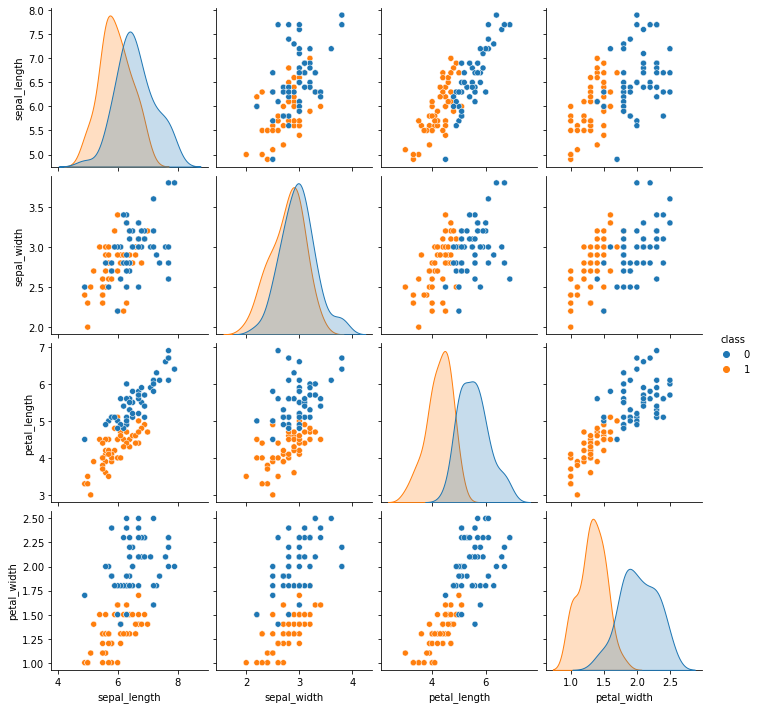

In [20]:
sns.pairplot(df_not_setosa, hue='class')

In [108]:
df_not_setosa_mini = df_not_setosa[['petal_length', 'petal_width', 'class']].copy()
mean = np.average(np.array(df_not_setosa_mini)[:,0:2], axis=0)

df_not_setosa_mini_centered = df_not_setosa_mini - np.append(mean, 0)
y = df_not_setosa_mini_centered['class']
X = df_not_setosa_mini_centered.loc[:, df_not_setosa_mini_centered.columns != 'class']
min_accuracy(X, y)

0.9090909090909091

**Now we solved this issue.**

# MLP

Implement a class that builds an MLP with both variable depth D (number of layers) and
variable number of neurons n_i

for each layer i = 1, ..., D. Produce outputs on the ZIP Dataset

In [173]:
from IPython.display import clear_output
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [172]:
#imports
zip_train = "zip.train"
df_zip = pd.read_csv('zip/'+zip_train, sep=' ',header=None)
df_zip = df_zip[df_zip.columns[:-1]]
y_zip = df_zip[df_zip.columns[0]]
X_zip = df_zip[df_zip.columns[1:]]

In [90]:
def plotNum(num):
    fig, ax = plt.subplots()
    min_val, max_val = -1, 1
    intersection_matrix = np.random.randint(0, 10, size=(max_val, max_val))
    ax.matshow(num, cmap=plt.cm.Blues)
    plt.show()

Let's inspect the training data

6.0


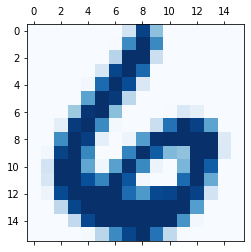

5.0


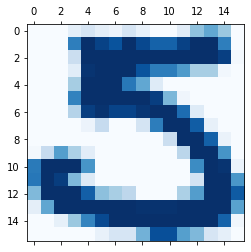

4.0


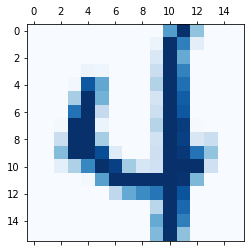

7.0


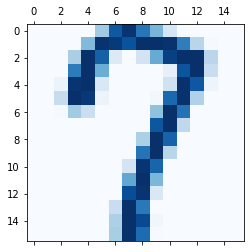

3.0


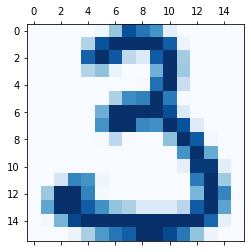

6.0


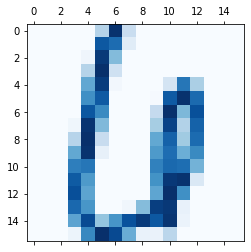

3.0


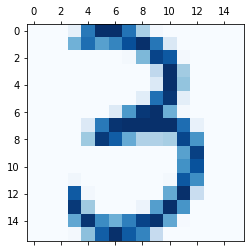

1.0


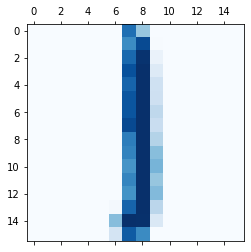

0.0


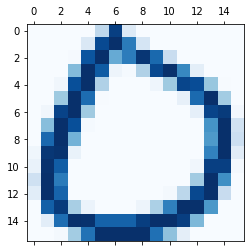

1.0


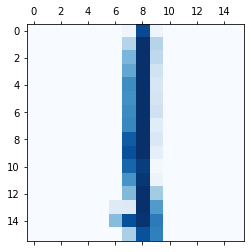

7.0


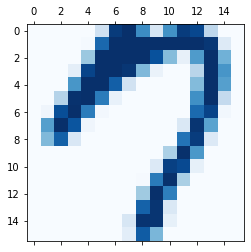

0.0


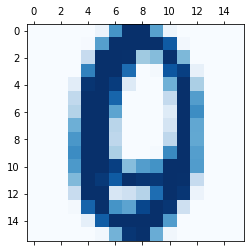

1.0


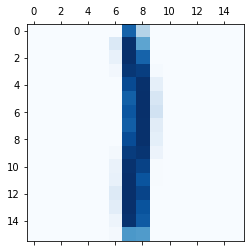

1.0


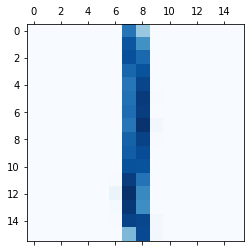

7.0


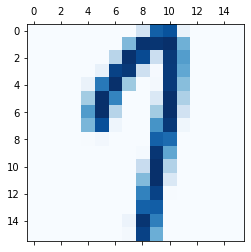

7.0


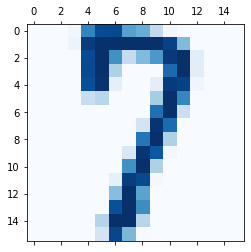

4.0


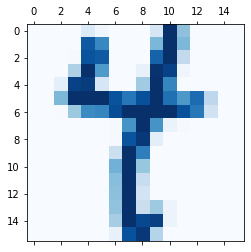

8.0


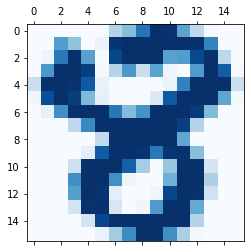

0.0


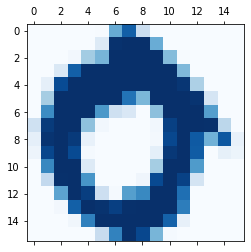

1.0


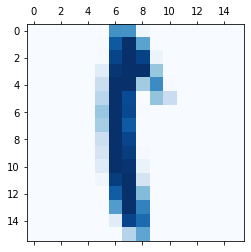

In [94]:
for i in range(20):
    print(df_zip.iloc[i][0])
    plotNum(df_zip.iloc[i][1:].to_numpy().reshape([16,16]))

In [112]:
class Layer:
    
    #A building block. Each layer is capable of performing two things:
    #- Process input to get output:           output = layer.forward(input)
    
    #- Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
    
    #Some layers also have learnable parameters which they update during layer.backward.
    
    def __init__(self):
        # Here we can initialize layer parameters (if any) and auxiliary stuff.
        # A dummy layer does nothing
        pass
    
    def forward(self, input):
        # Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        
        # A dummy layer just returns whatever it gets as input.
        return input
    def backward(self, input, grad_output):
        # Performs a backpropagation step through the layer, with respect to the given input.
        
        # To compute loss gradients w.r.t input, we need to apply chain rule (backprop):
        
        # d loss / d x  = (d loss / d layer) * (d layer / d x)
        
        # Luckily, we already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        
        # If our layer has parameters (e.g. dense layer), we also need to update them here using d loss / d layer
        
        # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

In [113]:
class ReLU(Layer):
    def __init__(self):
        # ReLU layer simply applies elementwise rectified linear unit to all inputs
        pass
    
    def forward(self, input):
        # Apply elementwise ReLU to [batch, input_units] matrix
        relu_forward = np.maximum(0,input)
        return relu_forward
    
    def backward(self, input, grad_output):
        # Compute gradient of loss w.r.t. ReLU input
        relu_grad = input > 0
        return grad_output*relu_grad

In [114]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        # A dense layer is a layer which performs a learned affine transformation:
        # f(x) = <W*x> + b
        
        self.learning_rate = learning_rate
        self.weights = np.random.normal(loc=0.0, 
                                        scale = np.sqrt(2/(input_units+output_units)), 
                                        size = (input_units,output_units))
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        # Perform an affine transformation:
        # f(x) = <W*x> + b
        
        # input shape: [batch, input_units]
        # output shape: [batch, output units]
        
        return np.dot(input,self.weights) + self.biases
    
    def backward(self,input,grad_output):
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = np.dot(grad_output, self.weights.T)
        
        # compute gradient w.r.t. weights and biases
        grad_weights = np.dot(input.T, grad_output)
        grad_biases = grad_output.mean(axis=0)*input.shape[0]
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        
        # Here we perform a stochastic gradient descent step. 
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

In [160]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    # Compute crossentropy from logits[batch,n_classes] and ids of correct answers
    logits_for_answers = logits[np.arange(len(logits)),reference_answers.astype(int)]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy
def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    # Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers.astype(int)] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

In [161]:
network = []
network.append(Dense(X_train.shape[1],100))
network.append(ReLU())
network.append(Dense(100,200))
network.append(ReLU())
network.append(Dense(200,10))
def forward(network, X):
    # Compute activations of all network layers by applying them sequentially.
    # Return a list of activations for each layer. 
    
    activations = []
    input = X
    # Looping through each layer
    for l in network:
        activations.append(l.forward(input))
        # Updating input to last layer output
        input = activations[-1]
    
    assert len(activations) == len(network)
    return activations
def predict(network,X):
    # Compute network predictions. Returning indices of largest Logit probability
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)
def train(network,X,y):
    # Train our network on a given batch of X and y.
    # We first need to run forward to get all layer activations.
    # Then we can run layer.backward going from last to first layer.
    # After we have called backward for all layers, all Dense layers have already made one gradient step.
    
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    # Propagate gradients through the network
    # Reverse propogation as this is backprop
    for layer_index in range(len(network))[::-1]:
        layer = network[layer_index]
        
        loss_grad = layer.backward(layer_inputs[layer_index],loss_grad) #grad w.r.t. input, also weight updates
        
    return np.mean(loss)

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X_zip.to_numpy(), y_zip.to_numpy(), test_size=0.2, random_state=42)

Epoch 11
Train accuracy: 0.9998285322359396


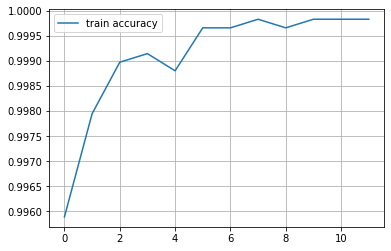

In [166]:
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]
from IPython.display import clear_output
train_log = []
val_log = []
for epoch in range(12):
    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [195]:
class Dense():
    def __init__(self, input_units, output_units, theta=1):
        self.theta = theta
        self.weights = np.random.randint(2, size = (input_units,output_units))
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        return np.dot(input,self.weights) + self.biases

class MLP():
    def __init__(self, network):
        self.network = network
        pass

    def forward(self, X):
        activations = []
        input = X
        # Looping through each layer
        for l in self.network:
            activations.append(l.forward(input))
            # Updating input to last layer output
            input = activations[-1]

        assert len(activations) == len(network)
        return activations

    def fit(self,X,y):
        layer_activations = self.forward(X)
        layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
        logits = layer_activations[-1]
    
    def predict(self,X):
        logits = self.forward(X)[-1]
        return logits.argmax(axis=-1)

In [196]:
X_train, X_test, y_train, y_test = train_test_split(X_zip.to_numpy(), y_zip.to_numpy(), test_size=0.2, random_state=42)

In [204]:
network = []
network.append(Dense(X_train.shape[1],100))
network.append(Dense(100,200))
network.append(Dense(200,10))

mlp = MLP(network)
mlp.fit(X_train,y_train)
print(mlp.predict(X_test))

[2 2 2 ... 2 2 2]
